# Trauma Mortality: Project Design
> [To Do](#To-Do) | [Quick Start](#Quick-Start) | [Contacts](#Contacts) | [Timelines](#Timelines) | [Methodology](#Methodology) | [Dependencies](#Dependencies) | [Deployment Architecture](#Deployment-Architecture) | [Testing and Evaluation](#Testing-and-Evaluation)

>> [Data Ingestion](#Data-Ingestion) | [Pivots & Resampling](#Pivots-and-Resampling) | [Merging](#Merging) | [Exploration](#EXPLORATION)

## To Do:
- Write up results and find funding to continue development!

> #### Wishlist
>> double-back for transfusions, input/output fluids; nosocomial from problem list, abx order

________________________________________________________
## Quick Start

- Point global variables to raw data path. 
- 1_Trauma_Data_Preparation prepares the data for analysis
- 2_Trauma_Model applies some final cleaning steps and fits models

________________________________________________________
## Contacts

**PCCI**
- _Data Scientist:_ David Watkins | john.watkins@phhs.org | 214-590-3852
- _Medical Director:_ Manjula Julka | manjula.julka@phhs.org | 214-590-1168
- _Project Manager:_ Pack Mam | phakdei.mam@phhs.org | 214-590-3890
- _Engagement Manager:_ Rae Esters | raeona.esters@phhs.org | 214-590-3845

**Stakeholders**
- _Principal Investigator:_ Adam Starr | adam.starr@phhs.org | 214-648-6428
- _Co-investigator:_ Hayden Box | hayden.box@phhs.org | 
________________________________________________________
## Timelines 

Date | Milestone 
---: | :---
Apr 2015 | IRB submitted
Sep 2016 | PCCI re-engages with stakeholders
Oct 2016 | Cohort discovery and data engineering
Nov 2016 | Trauma registry access request
Jan 2017 | Trauma registry received (2009-2016)
Feb 2017 | Data exploration and model building begins
Mar 2017 | Candidate models developed
Apr 2017 | Model presented to stakeholder

________________________________________________________
## Methodology 
**Out-of-ICU model validation:** Generate misclassification table, ROC curve, C-statistic

**Predict mortality:** Classification model comparison (logistic regression, decision trees, random forest, etc.)

**Unit of analysis:** [12] hour groupings of an inpatient stay associated with a trauma activation, with optional resampling to test for bias, and optimize time-to-intervene.

**Outcome:** mortality within hospital stay
________________________________________________________
## Dependencies 
### Data Sources and Connections
- Clinical + Demographics: Connection to Parkland's Clarity and EDW data via Composite ODBC
- OOICU Scores: CSV from PiecesT5 ModelEvaluationHistory (SQL Server)
- Cohort from Trauma Registry: CSV from Parkland Trauma Registrar, matched to Epic Encounter IDs using MRN and date

### Software
- Python 3.6 
- SQLite

### Libraries
- Pandas
- NumPy
- CSV
- SQLite3
- Matplotlib
- Seaborn
- FancyImpute (mice.py - local import)
- MissingNo
________________________________________________________
## Deployment Architecture
**N/A**
________________________________________________________
## Testing and Evaluation
Grouped K-fold cross-validation (on encounter), evaluate success on PPV, AUC
________________________________________________________
## Challenges
- Low quality trauma registry data
- Missing data for culture, procedures, labs, vitals

In [1]:
# Load Dependencies
from time import time
import pandas as pd
import csv
import re
import numpy as np
import sqlite3 as lite
import missingno as mn
import seaborn as sns
import collections
from matplotlib import pyplot as plt

sns.set(style="white", color_codes=True)
%matplotlib inline

In [2]:
# Global variables
## Set number of hours to use when resampling clinical data
TIME_BINS = '12H'

## Set maximum number of time periods to include per encounter
MAX_PERIODS = 60

## Set number of jobs to use in parallel (-1 = max)
N_JOBS = 3

## Set base path for raw data
#DATA_PATH = '//sc-acs228-1.parknet-ad.pmh.org/users$/P73501/Documents/UserDrive/Projects/Trauma/Data/raw/'
DATA_PATH = 'T:\\Trauma\\Code\\Akshay_review\\v2\\'
#DATA_PATH = '//sc-acs228-1.parknet-ad.pmh.org/PCCIFS/Trauma/data/raw/'

## Set default SQLite database file; default will be in same path as raw data files
SQLITE_DB = DATA_PATH + "trauma_mortality_backup_tast.db"

In [3]:
## Replace spaces in column names (caused by IDT/WebBI) with underscores; make all headers lowercase
### Inputs: list of dataframes, list of dataframe names
### Outputs: None. Makes changes in place.
def ColumnSpaceToUnderscore(all_data, file_list):   
    i = 0
    while i < len(file_list):
        column_dict = {}
        for j in range(0, len(all_data[file_list[i]].columns.values)):
            column_dict[all_data[file_list[i]].columns.values[j]] = all_data[file_list[i]].columns.values[j].replace(' ', '_')
        all_data[file_list[i]].rename(columns=column_dict, inplace=True)
        all_data[file_list[i]].rename(columns=str.lower, inplace=True)
        i += 1
    print('Column names are now lower-case and free of spaces.')

In [4]:
## Confirm correct datatypes coming across in all input fields
def CheckDataTypes(list_of_dataframes, file_list):
    i = 0
    while i < len(file_list):
        print("  Table:", file_list[i])
        print(all_data[file_list[i]].dtypes, "\n")
        i += 1

In [5]:
## Write selected dataframe to default SQLite database, replacing if found
def DataFrameToSQL(df, df_name):
    connection = lite.connect(SQLITE_DB)
    with connection:
        df.to_sql(df_name, connection, schema = None, if_exists='replace', index=False)
        print('%s backed up to default SQLite database.' % df_name)

In [6]:
## Retrieve SQL table from default SQLite database and store as a dataframe
def SQLToDataFrame(table_name, date_columns=[]):
    connection = lite.connect(SQLITE_DB)
    sql = 'select * from ' + table_name
    with connection:
        df = pd.read_sql(sql, connection, parse_dates=date_columns)
    return(df)

## Setup Data Ingestion

In [31]:
## List of input file names 
file_list = ['admission', 'dx', 'flowsheet', 'lab', 'patient', 'service_team', 'rx','registry']

## Dict of input files' date columns (by index) to convert 
date_columns = {'admission': [2,3],  'dx': [2], 'flowsheet': [4], 
                'lab': [4, 5], 'patient': [7, 8], 'service_team': [], 'rx': [3],'registry' : [1]}

## Initialize empty OrderedDict to contain working dataframes. 
all_data = collections.OrderedDict()

## Read tsv files into Pandas dataframes, and store in dict
### Note: parse_dates is quite slow compared to pd.to_datetime
for file in file_list:
    file_path = DATA_PATH + file + '.txt'
    df = pd.read_csv(file_path, sep = '\t', header = 0, thousands = ',',
                     parse_dates = date_columns[file], infer_datetime_format=True)
    all_data[file] = df
    print(file, df.shape)

admission (22676, 7)
dx (367756, 12)
flowsheet (8122022, 7)
lab (1276663, 7)
patient (22676, 13)
service_team (31033, 2)
rx (254462, 11)
registry (39377, 6)


In [44]:
all_data['dx']#.dxname.nunique()

,patientkey,encounterkey,dxstartdate,hospitaldiagnosis,emergencydepartmentdiagnosis,dxname,dxdisplayname,dxtype,dxstatus,dxpresentonadmission,dxcodetype,dxcode
0,11179,16441082,2014-01-10,NaN,0.0,UTI (lower urinary tract infection),"Urinary tract infection, site not specified",Encounter Diagnosis,Active,True,ICD-9-CM,599.0
1,11179,16441082,2014-01-10,NaN,0.0,Lumbar vertebral fracture,Closed fracture of lumbar vertebra without men...,Encounter Diagnosis,Active,True,ICD-9-CM,805.4
2,11179,16441082,2014-01-10,NaN,0.0,HTN (hypertension),Unspecified essential hypertension,Encounter Diagnosis,Active,True,ICD-9-CM,401.9
3,11179,16441082,2014-01-10,NaN,0.0,Lumbar compression fracture,Closed fracture of lumbar vertebra without men...,Encounter Diagnosis,Active,True,ICD-9-CM,805.4
4,11179,16441082,2014-01-10,NaN,0.0,Gait instability,Abnormality of gait,Encounter Diagnosis,Active,True,ICD-9-CM,781.2
5,11179,16441082,2014-01-10,NaN,NaN,Delirium due to conditions classified elsewhere,Delirium due to conditions classified elsewhere,Billing Diagnosis,Active,False,ICD-9-CM,293.0
6,11179,16441082,2014-01-10,NaN,NaN,"Urinary tract infection, site not specified","Urinary tract infection, site not specified",Billing Diagnosis,Active,False,ICD-9-CM,599.0
7,11179,16441082,2014-01-10,NaN,NaN,Other and unspecified special symptom or syndr...,Other and unspecified special symptom or syndr...,Billing Diagnosis,Active,False,ICD-9-CM,307.9
8,11179,16441082,2014-01-10,NaN,NaN,"Hemiplegia affecting unspecified side, late ef...","Hemiplegia affecting unspecified side, late ef...",Billing Diagnosis,Active,True,ICD-9-CM,438.20
9,11179,16441082,2014-01-10,NaN,NaN,Personal history of fall,Personal history of fall,Billing Diagnosis,Active,True,ICD-9-CM,V15.88


In [9]:
ColumnSpaceToUnderscore(all_data, file_list)

Column names are now lower-case and free of spaces.


In [13]:
CheckDataTypes(all_data, file_list)

  Table: admission
pat_enc_csn_id                int64
hsp_account_id                int64
hosp_admsn_time      datetime64[ns]
hosp_dischrg_time    datetime64[ns]
department_name              object
specialty                    object
lengthofstayhours           float64
dtype: object 

  Table: dx
patientkey                               int64
encounterkey                             int64
dxstartdate                     datetime64[ns]
hospitaldiagnosis                      float64
emergencydepartmentdiagnosis           float64
dxname                                  object
dxdisplayname                           object
dxtype                                  object
dxstatus                                object
dxpresentonadmission                      bool
dxcodetype                              object
dxcode                                  object
dtype: object 

  Table: flowsheet
flowname                   object
flowdescription            object
flowid                      int64


In [10]:
## Store tables in temporary SQLite db
## Initialize SQLite database for temporary storage
connection = lite.connect(SQLITE_DB)

### /with/ will automatically close connection when complete

#flavor='sqlite',

with connection:
    i = 0
    while i < len(file_list):
        all_data[file_list[i]].to_sql(file_list[i], 
                                      connection, 
                                      schema = None, 
                                      if_exists='replace',
                                      index=False)
        print(file_list[i], 'table backed up to SQLite.')
        i+=1
        
    connection.commit()

admission table backed up to SQLite.
dx table backed up to SQLite.
flowsheet table backed up to SQLite.
lab table backed up to SQLite.
patient table backed up to SQLite.
service_team table backed up to SQLite.
rx table backed up to SQLite.
registry table backed up to SQLite.


In [98]:
# for each in all_data:
#     print(str(each))
#     print(all_data[each].head(2))

In [99]:
# ## Read in morphine-equivalent-dosage file to convert RX's
# mde = pd.read_csv(DATA_PATH + 'mde.txt', sep = '\t', header = 0)
# mde.rx_short_name = mde.rx_short_name.astype(str).str.upper()
# mde.rx_route_type = mde.rx_route_type.astype(str).str.upper()
# connection = lite.connect(SQLITE_DB)
# with connection:
#     mde.to_sql('mde',connection,schema = None,if_exists='replace',index=False) #flavor='sqlite',
#     rx_mde = pd.read_sql('select rx.*, mde.conversion_to_oral_morphine from rx join mde on substr(rx.rx_short_name, 1, length(rx.rx_short_name)-1) = mde.rx_short_name and rx.rx_route_type = mde.rx_route_type', connection, parse_dates=['rx_administration_instant'])
#     DataFrameToSQL(rx_mde, 'rx_mde')
#     connection.commit()

# rx=rx_mde

## Data Ingestion

In [101]:
# CheckDataTypes(all_data, file_list)

In [7]:
## Distinct patients/encounters for each data set
for each in file_list:
    if each == 'flowsheet':
        print(each, all_data[each].patientkey.nunique())
    elif each == 'service_team':
        print(each, all_data[each].encounterepiccsn.nunique())
    elif each in ('admission'):
        print(each, all_data[each].pat_enc_csn_id.nunique())
   
    else:
        try:
            print(each, all_data[each].patientkey.nunique())
        except:
            pass
    

NameError: name 'file_list' is not defined

In [8]:
## Assign new data frame names to all input data sets
admission, dx, flowsheet, lab, patient, service_team, rx, registry = iter(all_data.values())
#del all_data

NameError: name 'all_data' is not defined

In [20]:
#flowsheet

In [12]:
del all_data

In [13]:
## Extract date from admission for joining 
admission['adm_date'] = admission['hosp_admsn_time'].dt.date
admission['adm_date'] = pd.to_datetime(admission['adm_date'])

### Pivots and Resampling

In [14]:
# Utility function: downsample dates with hierarchical index
def DateGrouper(df, num_levels=3):
    level_values = df.index.get_level_values
    print(level_values)
    # Downsampling method not defined; make sure to chain with .sum(), .last(), etc.
    base_levels = list(range(0, num_levels-1))
    return (df.groupby([level_values(i) for i in base_levels]
                       +[pd.Grouper(freq=TIME_BINS, level=-1)]))

In [15]:
# Utility function: pivot long results into wide format
### Inputs: dataframe, hierarchical index as list, date column, field name column, field value column, TIME_BINS
### Output: pivoted dataframe
def LongToWide(df, index_fields, date_field, name_field, value_field):
    df_temp = df.copy()
    
    full_index = index_fields
    full_index.append(name_field)
    index_fields.append(date_field)
    #df_temp.set_index(full_index, inplace=True, drop=False)
    
    ## Replace spaces in name_field with underscores
    df_temp[name_field].replace(regex=True, inplace=True, to_replace=r'[ ]', value=r'_')
    ## Remove commas in name_field 
    df_temp[name_field].replace(regex=True, inplace=True, to_replace=r'[,]', value=r'')
    
    #print(index_fields)
    
     ## Use DateGrouper to resample to TIME_BINS global var, using last observation
    #df_temp = DateGrouper(df_temp, num_levels=len(index_fields)).last()

    index_fields.remove(name_field)
    
    df_pivot = pd.pivot_table(df_temp, 
                             index=index_fields,
                             values = value_field,
                             columns = name_field,
                             aggfunc = max)#np.max)#np.mean)#np.nanmax) 
    
    ## Use DateGrouper to resample to TIME_BINS global var, using last observation
    #df_pivot = DateGrouper(df_pivot, num_levels=len(index_fields)).last()
    
    df_pivot.reset_index(inplace=True)
        
    # Convert all columns to lower-case
    df_pivot.rename(columns=str.lower, inplace=True)
    
    return(df_pivot)

In [17]:
 ## Remove rows with missing measure values
flow_na_removed = flowsheet.dropna(axis=0, how='any', subset=['flowvalue'], inplace=False)

## Replace spaces in flowname with underscores
flow_na_removed['flowname'].replace(regex=True, inplace=True, to_replace=r'[ ]', value=r'_')

## Remove commas in flowname 
flow_na_removed['flowname'].replace(regex=True, inplace=True, to_replace=r'[,]', value=r'')

flow_numerical_columns = ['PULSE_OXIMETRY', 'TEMPERATURE', 'PULSE',
                          'BLOOD_PRESSURE', 'RESPIRATIONS', 'PKMOD_R_CPN_GLASGOW_COMA_SCALE_SCORE']

flow_cat_columns = []

flow_all_columns = flow_numerical_columns + flow_cat_columns

C:\Users\P87979\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5886: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [18]:
%%time

flow_pivot = LongToWide(df=flow_na_removed[flow_na_removed.flowname.isin(flow_all_columns)], 
                        index_fields=['patientkey', 'encounterkey'], 
                        date_field='flowdatetime', 
                        name_field='flowname', 
                        value_field='flowvalue')

Wall time: 30min 19s


In [19]:
# Select blood pressure measures, convert to strings, split on "/" character, convert to dictionary
flow_pivot = flow_pivot.set_index(['patientkey','encounterkey','flowdatetime'])
bp_split = flow_pivot.blood_pressure.str.split('/').to_dict()


In [20]:
# Create dataframe from blood pressure dict, transpose, rename columns
bp_df = pd.DataFrame.from_dict(bp_split, orient='columns').T.rename(columns = {0: 'systolic', 1: 'diastolic'}) 

# Merge bp dataframe back into pivoted flowsheet dataframe
flow_temp = flow_pivot.reset_index().join(bp_df, how="left", on=['patientkey','encounterkey','flowdatetime'])#pd.merge(flow_pivot2, bp_df, how="left", left_index=True, right_index=True)

flow_pivot = flow_temp

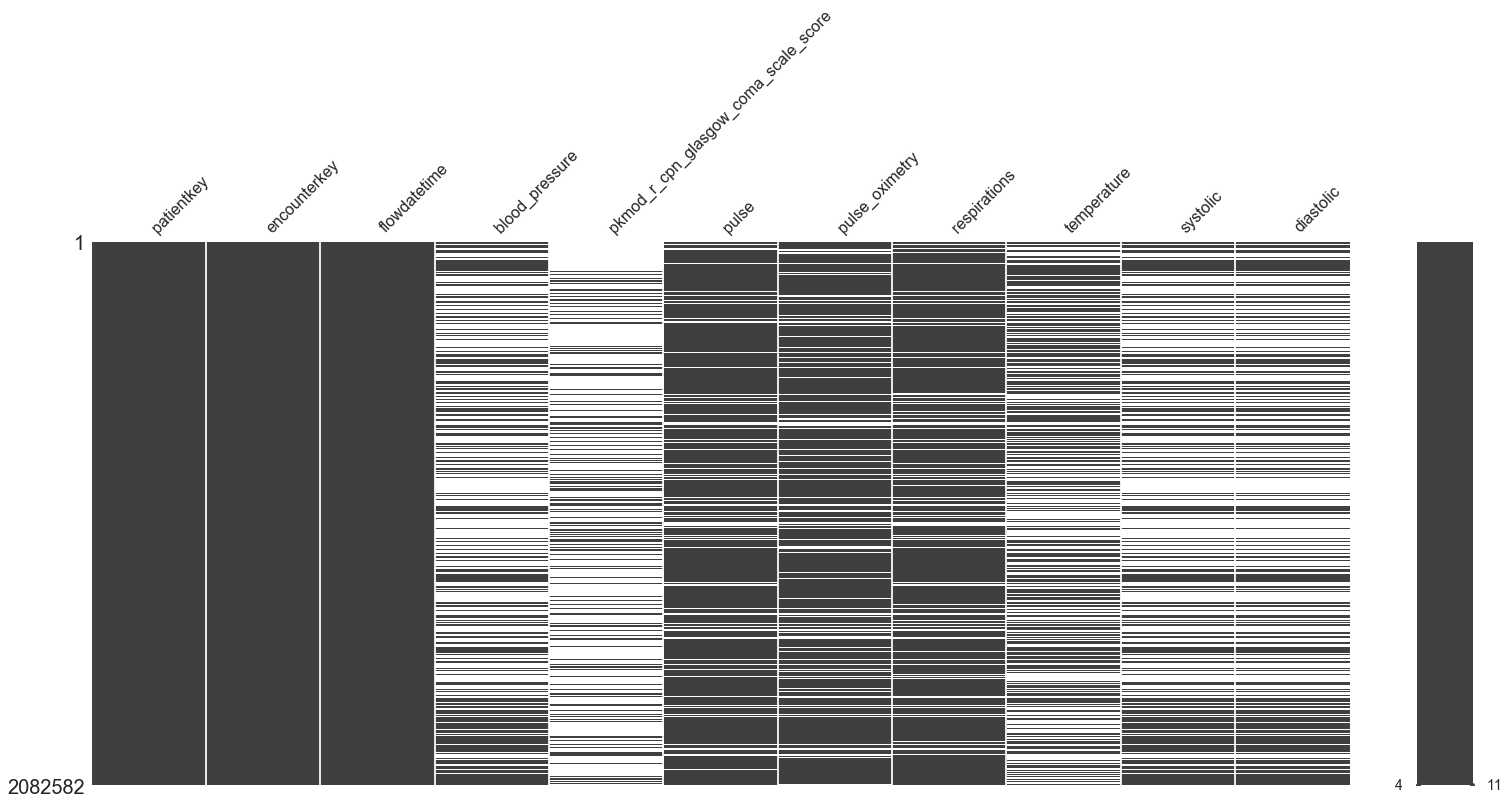

In [21]:
mn.matrix(flow_pivot)

In [151]:
lab = lab.replace({'labcommonname': {'POC HEMOGLOBIN': 'HEMOGLOBIN', 'GLUCOSE RANDOM': 'GLUCOSE',\
                                       'GLUCOSE UA': 'GLUCOSE', 'GLUCOSEPOC': 'GLUCOSE', 'POC POTASSIUM': 'POTASSIUM'}})

In [152]:
%%time
labs_pivot = LongToWide(df=lab, 
                        index_fields=['patientkey', 'encounterkey'], 
                        date_field='labcollectiontime', 
                        name_field='labcommonname', 
                        value_field='labvalue')

Wall time: 5min 9s


In [153]:
%%time
labs_flag_pivot_base = LongToWide(df=lab, 
                                  index_fields=['patientkey', 'encounterkey'], 
                                  date_field='labcollectiontime', 
                                  name_field='labcommonname', 
                                  value_field='labflag')

Wall time: 4min 59s


In [154]:
## Add _flag suffix to all columns except index columns.
labs_flag_pivot = labs_flag_pivot_base.drop(['patientkey', 'encounterkey', 'labcollectiontime'],axis=1)\
                                      .add_suffix('_flag')\
                                      .join(labs_flag_pivot_base[['patientkey','encounterkey','labcollectiontime']])

In [104]:
## Join lab values and lab flag pivots on patient, encounter, and time
## OFF due to no flags in physiologic model
#labs_pivot = pd.merge(labs_pivot, labs_flag_pivot, on=['patientkey','encounterkey','labcollectiontime'], how='outer')

In [155]:
## Outer join labs and flowsheets on patient, encounter, and time
labs_flow_pivot = pd.merge(labs_pivot, flow_pivot, left_on=['patientkey','encounterkey','labcollectiontime'], 
                           right_on=['patientkey','encounterkey','flowdatetime'], how='outer')

In [156]:
## Merge different versions of patient and encounter keys to reduce confusion
labs_flow_pivot['patientkey'] = labs_flow_pivot['patientkey'].fillna(labs_flow_pivot.patientkey)
labs_flow_pivot['encounterkey'] = labs_flow_pivot['encounterkey'].fillna(labs_flow_pivot.encounterkey)
#labs_flow_pivot.drop(['patientkey','encounterkey'], axis=1, inplace=True)
labs_flow_pivot.head()

,patientkey,encounterkey,labcollectiontime,albumin,alt,ast,base_exc_art,bilirubin_total,co2,creatinine,...,wbc,flowdatetime,blood_pressure,pkmod_r_cpn_glasgow_coma_scale_score,pulse,pulse_oximetry,respirations,temperature,systolic,diastolic
0,11179,16441082,2014-01-10 14:30:00,NaN,NaN,NaN,NaN,NaN,22,1.22,...,4.12,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11179,16441082,2014-01-10 18:17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11179,16441082,2014-01-11 11:26:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11179,16441082,2014-01-11 16:14:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11179,16441082,2014-01-11 21:29:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [157]:
DataFrameToSQL(labs_flow_pivot, 'labs_flow_pivot')

labs_flow_pivot backed up to default SQLite database.


In [16]:
labs_flow_pivot = SQLToDataFrame(table_name='labs_flow_pivot', date_columns=['labcollectiontime', 'flowdatetime'])

## Data Processing

In [109]:
#rx = rx_mde

In [158]:
## Convert analgesic dosages to morphine-equivalent-doses
#rx['dose_mde'] = rx.conversion_to_oral_morphine * rx.rx_dose_min

## Re-index and select columns to include
rx = rx[['patientkey','encounterepiccsn', 'encounterkey', 'rxadministrationinstant', 'rxdosemin', 'rxshortname', 'rxroutetype']]
#rx.set_index(['patient_key', 'encounter_key', 'rx_administration_instant'], inplace=True)

In [111]:
## Downsample doses into TIME_BINS, taking sum of MDE dose
#rx_sum = DateGrouper(rx).sum()
#rx_sum.reset_index(inplace=True)
#rx_sum.sort_values(by='encounter_key').head()

In [18]:
labs_flow_pivot['current_datetime'] = labs_flow_pivot['flowdatetime'].fillna(labs_flow_pivot['labcollectiontime'])

In [160]:
merge_rx_flow = pd.merge(rx, labs_flow_pivot,
                         left_on=['patientkey', 'encounterkey', 'rxadministrationinstant'],
                         right_on=['patientkey', 'encounterkey', 'current_datetime'],
                         how='outer')

In [161]:
## Create coalesced time elapsed since first measurement
labs_flow_pivot2 = merge_rx_flow.copy()
labs_flow_pivot2['current_datetime'] = labs_flow_pivot2['flowdatetime'].fillna(labs_flow_pivot2['labcollectiontime']).fillna(merge_rx_flow['rxadministrationinstant'])

labs_flow_pivot2 = labs_flow_pivot2.join(labs_flow_pivot2.groupby(['patientkey','encounterkey']).current_datetime.min(), on=['patientkey','encounterkey'], rsuffix='_min')
labs_flow_pivot2['time_elapsed'] = (labs_flow_pivot2.current_datetime - labs_flow_pivot2.current_datetime_min)#.astype('m8[h]')
#labs_flow_pivot2.head()

In [162]:
labs_flow_pivot2.drop(['labcollectiontime', 'rxadministrationinstant', 'flowdatetime', 'blood_pressure'], axis=1, inplace=True)

In [163]:
%%time

rx_flow_labs = labs_flow_pivot2.copy().set_index(['patientkey','encounterkey','time_elapsed'], drop=True)
rx_sum = DateGrouper(rx_flow_labs[['rxdosemin']].copy()).sum().fillna(0).reset_index()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Wall time: 1min 1s


In [164]:
rx_sum['time_elapsed'] = rx_sum['time_elapsed'].astype('timedelta64[h]')

In [165]:
rx_sum['time_sequence'] = rx_sum.time_elapsed.astype('timedelta64[h]') / np.timedelta64(12, 'h')

In [166]:
DataFrameToSQL(rx_sum, 'rx_sum')

rx_sum backed up to default SQLite database.


In [17]:
rx_sum = SQLToDataFrame(table_name='rx_sum')
# rx_sum['time_elapsed'] = rx_sum.time_sequence * np.timedelta64(12, 'h')

### Max/Min/Velocity

In [18]:
# time_vars = ['albumin', 'alt','ast', 'base_exc_art', 'bilirubin_total', 'co2', 'creatinine', 'crp', 'glucosepoc', 'glucose_random', \
#              'glucose_ua', 'hco3_art', 'hco3_ven', 'inr', 'lactate', 'lactate_bld_arterial', 'platelets','poc_inr', 'prealbumin',\
#              'sed_rate', 'wbc', 'pulse', 'pulse_oximetry','respirations', 'temperature', 'systolic', 'diastolic']

# labs = ['albumin', 'alt', 'ast', 'base_exc_art', 'bilirubin_total', 'co2', 'creatinine', 'crp', 'glucosepoc', 'glucose_random',\
#         'glucose_ua', 'hco3_art', 'hco3_ven', 'inr', 'lactate', 'lactate_bld_arterial', 'platelets', 'poc_inr', 'prealbumin', \
#         'sed_rate', 'wbc']

# vitals = list(set(time_vars) - set(labs))

labs = ['platelets', 'wbc', 'lactate', 'lactate_bld_arterial', 'base_exc_art', 'albumin', 'prealbumin', 'sed_rate', 'glucose', \
        'hco3_ven', 'hco3_art', 'inr', 'poc_inr', 'creatinine', 'bilirubin_total', 'ast', 'alt', 'crp', 'co2', 'potassium', 'hemoglobin']
vitals = ['temperature', 'pulse', 'pulse_oximetry', 'systolic']
time_vars = labs + vitals

max_vars = ['temperature', 'pulse', 'wbc', 'lactate', 'inr', 'creatinine', 'ast', 'alt', 'bilirubin_total', 'systolic', 'potassium']
min_vars = ['temperature', 'pulse', 'pulse_oximetry', 'platelets', 'base_exc_art', 'albumin', 'systolic', 'potassium', 'hemoglobin']
avg_vars = ['pulse', 'pulse_oximetry', 'systolic']

In [168]:
# ## Recode all labs and vitals as numeric
# for col in time_vars:
#     ## Use regex to search for symbols, text, and spaces; replace them with empty string; convert to numeric
#     try:
#         rx_flow_labs[col] = pd.to_numeric(re.sub(r"[<>A-z ]", "", rx_flow_labs[col]),errors='coerce')
#     except:
#         pass

## Recode all labs and vitals as numeric
for col in time_vars:
    ## Use regex to search for symbols, text, and spaces; replace them with empty string; convert to numeric
    if col in rx_flow_labs.columns.values:
        try:
            rx_flow_labs[col] = pd.to_numeric(rx_flow_labs[col].astype(str).str.replace(r"[<>A-z = ,]", ""))
        except TypeError:
            print(col, 'could not be converted!')
            pass

In [169]:
%%time 
flow_labs_to_fill = rx_flow_labs.copy().drop(['rxdosemin'],axis=1) #, 'rx_short_name', 'rx_route_type'
flow_labs_filled = flow_labs_to_fill.copy().groupby(level=[0,1]).fillna(method='ffill', downcast='infer').groupby(level=[0,1]).fillna(method='bfill', downcast='infer')

Wall time: 9min 42s


In [170]:
%%time 
flow_labs_last = DateGrouper(flow_labs_filled).last()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Wall time: 1min 11s


In [171]:
%%time
timevars_max = DateGrouper(flow_labs_filled.copy()[max_vars]).max()
timevars_max = timevars_max.add_suffix('_max')

timevars_min = DateGrouper(flow_labs_filled.copy()[min_vars]).min()
timevars_min = timevars_min.add_suffix('_min')

timevars_avg = DateGrouper(flow_labs_filled.copy()[avg_vars]).mean()
timevars_avg = timevars_avg.add_suffix('_avg')


## Calculate within-period max-min difference
#itals_max = DateGrouper(flow_labs_filled.copy()[vitals]).max()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Wall time: 3min 2s


In [126]:
# %%time

# vitals_min = DateGrouper(flow_labs_filled.copy()[vitals]).min()
# vitals_diff = vitals_max.astype(float) - vitals_min.astype(float)
# vitals_diff = vitals_diff.add_suffix('_diff')
# #vitals_diff.sort_index().head()

In [172]:
rx_sum['time_elapsed'] = rx_sum.time_sequence * np.timedelta64(12, 'h')
rx_sum.set_index(keys=['patientkey', 'encounterkey', 'time_elapsed'], inplace=True)

In [173]:
rx_flow_labs = pd.merge(rx_sum, flow_labs_last, left_index=True, right_index=True, how='outer')
rx_flow_labs = pd.merge(rx_flow_labs, timevars_max, left_index=True, right_index=True, how='outer')
rx_flow_labs = pd.merge(rx_flow_labs, timevars_min, left_index=True, right_index=True, how='outer')
rx_flow_labs = pd.merge(rx_flow_labs, timevars_avg, left_index=True, right_index=True, how='outer')
rx_flow_labs.sort_index(level=1).head()

# rx_flow_labs = pd.merge(rx_sum, flow_labs_last, left_index=True, right_index=True, how='outer')
# rx_flow_labs = pd.merge(rx_flow_labs, vitals_diff, left_index=True, right_index=True, how='left')
# rx_flow_labs.sort_index(level=1).head()

rxdosemin  time_sequence  \
patientkey encounterkey time_elapsed                                
2796196    3968448      0 days 00:00:00        1.0            0.0   
                        0 days 12:00:00        0.4            1.0   
                        1 days 00:00:00        0.4            2.0   
                        1 days 12:00:00        0.2            3.0   
                        2 days 00:00:00        0.0            4.0   

                                         encounterepiccsn     rxshortname  \
patientkey encounterkey time_elapsed                                        
2796196    3968448      0 days 00:00:00       306963055.0  HYDROMORPHONE    
                        0 days 12:00:00       306963055.0  HYDROMORPHONE    
                        1 days 00:00:00       306963055.0  HYDROMORPHONE    
                        1 days 12:00:00       306963055.0  HYDROMORPHONE    
                        2 days 00:00:00       306963055.0  HYDROMORPHONE    

                                        rxroutetype  albumin   alt   ast  \
patientkey encounterkey time_elapsed                                       
2796196    3968448      0 days 00:00:00  PARENTERAL      4.0  19.0  25.0   
                        0 days 12:00:00  PARENTERAL      4.0  19.0  25.0   
                        1 days 00:00:00  PARENTERAL      4.0  19.0  25.0   
                        1 days 12:00:00  PARENTERAL      4.0  19.0  25.0   
                        2 days 00:00:00  PARENTERAL      4.0  19.0  25.0   

                                         base_exc_art  bilirubin_total  \
patientkey encounterkey time_elapsed                                     
2796196    3968448      0 days 00:00:00           NaN              0.7   
                        0 days 12:00:00           NaN              0.7   
                        1 days 00:00:00           NaN              0.7   
                        1 days 12:00:00           NaN              0.7   
                        2 days 00:00:00           NaN              0.7   

                                             ...       pulse_oximetry_min  \
patientkey encounterkey time_elapsed         ...                            
2796196    3968448      0 days 00:00:00      ...                     92.0   
                        0 days 12:00:00      ...                     92.0   
                        1 days 00:00:00      ...                     92.0   
                        1 days 12:00:00      ...                     92.0   
                        2 days 00:00:00      ...                     92.0   

                                         platelets_min  base_exc_art_min  \
patientkey encounterkey time_elapsed                                       
2796196    3968448      0 days 00:00:00          227.0               NaN   
                        0 days 12:00:00          227.0               NaN   
                        1 days 00:00:00          227.0               NaN   
                        1 days 12:00:00          227.0               NaN   
                        2 days 00:00:00          227.0               NaN   

                                         albumin_min  systolic_min  \
patientkey encounterkey time_elapsed                                 
2796196    3968448      0 days 00:00:00          4.0         144.0   
                        0 days 12:00:00          4.0         144.0   
                        1 days 00:00:00          4.0         116.0   
                        1 days 12:00:00          4.0         135.0   
                        2 days 00:00:00          4.0         130.0   

                                         potassium_min  hemoglobin_min  \
patientkey encounterkey time_elapsed                                     
2796196    3968448      0 days 00:00:00            3.8            11.5   
                        0 days 12:00:00            3.8            11.5   
                        1 days 00:00:00            3.8            11.5   
                        1 days 

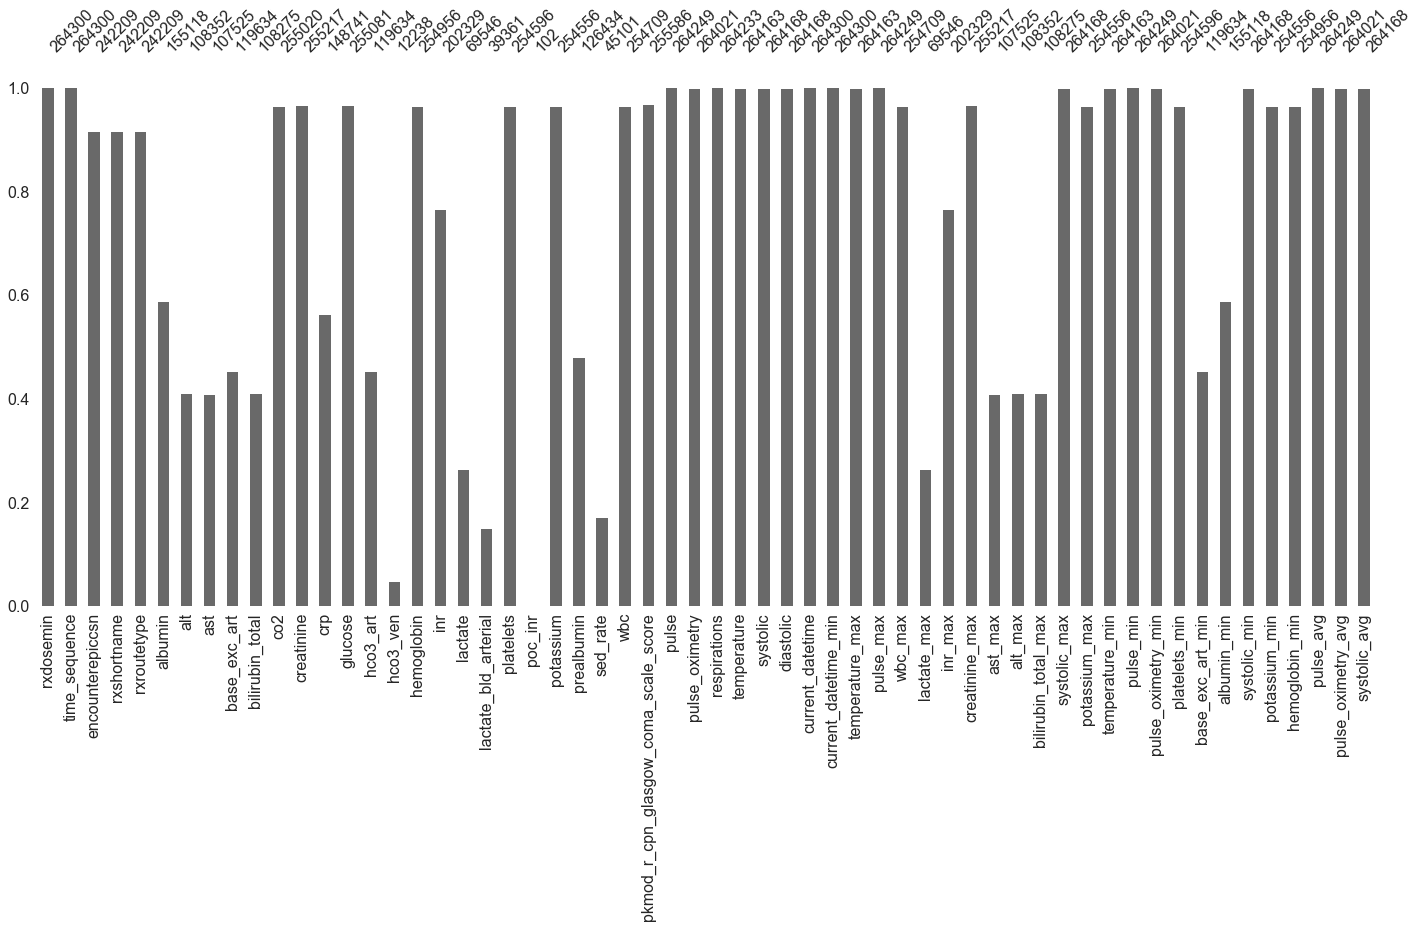

In [174]:
#Sort data ascending by nullity
sorted_data = mn.nullity_sort(rx_flow_labs, sort='ascending')
mn.bar(sorted_data)

In [175]:
rx_flow_labs2 = rx_flow_labs.copy().reset_index()

## SQLite mangles timedelta fields, so create a durable time_sequence that is just a counter for observation windows
rx_flow_labs2['time_sequence'] = rx_flow_labs2.time_elapsed / np.timedelta64(12, 'h')
DataFrameToSQL(rx_flow_labs2.drop('time_elapsed',axis=1), 'rx_flow_labs')

rx_flow_labs backed up to default SQLite database.


In [19]:
rx_flow_labs = SQLToDataFrame(table_name='rx_flow_labs', date_columns=['current_datetime', 'current_datetime_min'])

# ## Reconvert durable time sequence into time elapsed (timedelta)
# rx_flow_labs['time_elapsed'] = rx_flow_labs.time_sequence * np.timedelta64(12, 'h')
# rx_flow_labs.set_index(['patientkey', 'encounterkey', 'time_elapsed'], inplace=True)

## Merging

In [176]:
# def DataFrameToSQL1(df, df_name):
#     connection = lite.connect(DATA_PATH+'trauma_tast_merge_temp1.db')
#     with connection:
#         df.to_sql(df_name, connection, schema = None, if_exists='replace', index=False)
#         print('%s backed up to default SQLite database.' % df_name)

In [177]:
# DataFrameToSQL1(merge_temp1,'merge_temp1')

C:\Users\P87979\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\io\sql.py:450: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  chunksize=chunksize, dtype=dtype)
C:\Users\P87979\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:2127: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype)


merge_temp1 backed up to default SQLite database.


In [20]:
#Left join ADMISSION with RX_FLOW_LABS
merge_temp1 = pd.merge(admission,rx_flow_labs.reset_index(), left_on = ['pat_enc_csn_id'], right_on = 'encounterepiccsn', how ='left')

In [21]:
## Left join merge_temp1 and patient on patientkey
merge_temp1 = pd.merge(merge_temp1, patient, 
                                   left_on='patientkey', 
                                   right_on='patientkey', 
                                   how='left')

In [22]:
service_team_sicu = service_team[service_team['serviceteamname'].isin(['SICU TEAM', 'NCC TEAM', 'NEURO CRITICAL CARE'])]
service_team_sicu = service_team_sicu.drop_duplicates(keep = 'first')

In [23]:
# Left join merge_temp1 and service_team where service team name in SICU team, NCC team, Neuro Critical care team
merge_temp1 = pd.merge(merge_temp1,service_team_sicu, left_on='pat_enc_csn_id', right_on = 'encounterepiccsn',how = 'left')

In [24]:
## Remove registry rows with invalid identifers
registry_clean = registry[registry.mrn!='0 0 0 0 0 0 0 0']
registry_clean = registry_clean[registry_clean.mrn!='                    '] 

## Remove registry rows with missing identifiers
registry_clean = registry_clean[pd.isnull(registry_clean.mrn)==False]

## Remove invalid character from registry identifier field
registry_clean.mrn.replace(regex=True, inplace=True, to_replace=r'[`]', value='')

## Convert registry identifier to float
registry_clean.mrn = registry_clean.mrn.astype(float)

## Remove invalid characters from ISS variable
registry_clean.iss = registry_clean.iss[~registry_clean.iss.isin(['   ','UA'])]

## Convert date of arrival to datetime
registry_clean['Date of Arrival'] = pd.to_datetime(registry_clean['date_of_arrival'])

In [25]:
## Left join merge_temp1 and registry_clean on ['mrn', 'date_of_arrival']
merge_temp1 = pd.merge(merge_temp1, registry_clean, 
                                   left_on=['primarymrn', 'adm_date'],
                                   right_on=['mrn', 'date_of_arrival'], 
                                   how='left')

In [26]:
#Adding a sicu flag in case we need to subset only SICU patients from the cohort
merge_temp1['sicu_flag'] = 0
for team in ['SICU TEAM', 'NCC TEAM', 'NEURO CRITICAL CARE']:
    #df.ix[(df['A'] == df['B']), 'C'] = 0
    merge_temp1.loc[merge_temp1['serviceteamname']==team,'sicu_flag'] = 1

In [27]:
## Left join merge_temp1 and dx on ['patientkey', 'encounterkey']
merge_temp1_dx =  pd.merge(merge_temp1, dx, 
                    on=['patientkey', 'encounterkey'],
                     how='left')

In [28]:
#print(merge_temp1_dx.shape)
no_burn_id = merge_temp1_dx[merge_temp1_dx.dxname.str.contains('burn|Burn')==False]['pat_enc_csn_id'].unique()


In [29]:
## Including only non-burn patients
merge_temp1_dx = merge_temp1_dx[merge_temp1_dx.pat_enc_csn_id.isin(no_burn_id)].sort_values('pat_enc_csn_id')

In [163]:
# merge_temp1_dx[merge_temp1_dx.iss.isnull()][['pat_enc_csn_id','dxname',
#  'dxdisplayname',
#  'dxcodetype',
#  'dxcode', 'moi','iss','hosp_admsn_time']]#.dxname.unique() 370873770

In [30]:
merge_temp1 =  merge_temp1_dx.drop(['dxstartdate', 'hospitaldiagnosis',
       'emergencydepartmentdiagnosis', 'dxname', 'dxdisplayname', 'dxtype',
       'dxstatus', 'dxpresentonadmission', 'dxcodetype', 'dxcode'], axis = 1).drop_duplicates(keep = 'first')

In [33]:
# Deleting few dataframes to combat memory error
del labs_flow_pivot
del rx_sum
del rx_flow_labs

In [140]:
#merge_temp1[merge_temp1.pat_enc_csn_id == 342961659][['pat_enc_csn_id','time_sequence']]

In [141]:
# ## Left join admissions and height_weight
# merge_temp = pd.merge(merge_temp, height_weight,
#                      left_on='primary_mrn',
#                      right_on='mrn',
#                      how='left')

# ## Left join registry and admissions on mrn and date
# merge_temp = pd.merge(merge_temp, registry_clean, 
#                                    left_on=['primary_mrn', 'hosp_admsn_time'],
#                                    right_on=['mrn', 'date_of_arrival'], 
#                                    how='left')

In [73]:
# col_list2 = (['current_datetime', 'current_datetime_min',
#                 'time_sequence',
#                 'dose_mde', 
#                 'albumin', 'alt', 'ast',
#                 'base_exc_art', 'bilirubin_total', 'co2', 'creatinine', 'crp',
#                 'glucosepoc', 'glucose_random', 'glucose_ua', 'hco3_art',
#                 'hco3_ven', 'inr', 'lactate', 'lactate_bld_arterial', 'platelets',
#                 'poc_inr', 'prealbumin', 'sed_rate', 'wbc', 'albumin_flag',
#                 'alt_flag', 'ast_flag', 'base_exc_art_flag', 'bilirubin_total_flag',
#                 'co2_flag', 'creatinine_flag', 'crp_flag', 'glucosepoc_flag',
#                 'glucose_random_flag', 'glucose_ua_flag', 'hco3_art_flag',
#                 'hco3_ven_flag', 'inr_flag', 'lactate_flag',
#                 'lactate_bld_arterial_flag', 'platelets_flag', 'poc_inr_flag',
#                 'prealbumin_flag', 'sed_rate_flag', 'wbc_flag', 
#                 'pain_scale, pked_r_esi', 'pked_r_main_trauma_level_with_burn',
#                 'pked_r_trauma_md_cpn_glasgow_coma_scale_score',
#                 'pked__r_trauma_reason_for_activation', "pkip_r_cam-icu_feature_1",
#                 "pkip_r_cam-icu_feature_2", "pkip_r_cam-icu_feature_3",
#                 "pkip_r_cam-icu_feature_4", "pkip_r_cam-icu_score",
#                 "pkip_r_richmond_agitation_sedation_score_(rass)",
#                 'pkmod_r_cpn_glasgow_coma_scale_score', 'pkmod_r_vent_mode',
#                 'pkresp_r_percent_predicted_fev1_calculated',
#                 'pkresp_r_percent_predicted_fvc', 'pulse', 'pulse_oximetry',
#                 'respirations', 'temperature', 'systolic','diastolic', 
#                 'pulse_diff', 'pulse_oximetry_diff', 'respirations_diff', 'temperature_diff', 'systolic_diff', 'diastolic_diff'])

In [34]:
DataFrameToSQL(merge_temp1_dx,'merge_temp1_dx')

C:\Users\P87979\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:2127: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype)


merge_temp1_dx backed up to default SQLite database.


In [37]:
DataFrameToSQL(merge_temp1, 'merge_temp1')

C:\Users\P87979\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:2127: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype)


merge_temp1 backed up to default SQLite database.


In [77]:
# ## Join merge_rx_flow and merge_temp in SQLite to avoid Python memory error (!)
# connection = lite.connect(SQLITE_DB)
# sql = '''select distinct mt.*,  
#                 current_datetime, current_datetime_min,
#                 time_sequence,
#                 dose_mde, 
#                 albumin, alt, ast,
#                 base_exc_art, bilirubin_total, co2, creatinine, crp,
#                 glucosepoc, glucose_random, glucose_ua, hco3_art,
#                 hco3_ven, inr, lactate, lactate_bld_arterial, platelets,
#                 poc_inr, prealbumin, sed_rate, wbc, albumin_flag,
#                 alt_flag, ast_flag, base_exc_art_flag, bilirubin_total_flag,
#                 co2_flag, creatinine_flag, crp_flag, glucosepoc_flag,
#                 glucose_random_flag, glucose_ua_flag, hco3_art_flag,
#                 hco3_ven_flag, inr_flag, lactate_flag,
#                 lactate_bld_arterial_flag, platelets_flag, poc_inr_flag,
#                 prealbumin_flag, sed_rate_flag, wbc_flag, 
#                 pain_scale, pked_r_esi, pked_r_main_trauma_level_with_burn,
#                 pked_r_trauma_md_cpn_glasgow_coma_scale_score,
#                 pked__r_trauma_reason_for_activation, "pkip_r_cam-icu_feature_1",
#                 "pkip_r_cam-icu_feature_2", "pkip_r_cam-icu_feature_3",
#                 "pkip_r_cam-icu_feature_4", "pkip_r_cam-icu_score",
#                 "pkip_r_richmond_agitation_sedation_score_(rass)",
#                 pkmod_r_cpn_glasgow_coma_scale_score, pkmod_r_vent_mode,
#                 pkresp_r_percent_predicted_fev1_calculated,
#                 pkresp_r_percent_predicted_fvc, pulse, pulse_oximetry,
#                 respirations, temperature, systolic,diastolic, 
#                 pulse_diff, pulse_oximetry_diff, respirations_diff, temperature_diff, systolic_diff, diastolic_diff
#         from merge_temp mt 
#         left join rx_flow_labs mrf 
#             on mrf.patient_key = mt.patient_key 
#             and mrf.encounter_key = mt.encounter_key
# '''
# merge_all = pd.read_sql(sql, connection, 
#                         parse_dates=['date_of_arrival', 'birth_date', 'death_date', 'hosp_admsn_time', 'hosp_dischrg_time', 'current_datetime', 'current_datetime_min'])

In [38]:
merge_all = merge_temp1.copy()

In [39]:
merge_all['time_elapsed'] = merge_all.time_sequence * np.timedelta64(12, 'h')
merge_all['time_elapsed'].fillna(0, inplace=True)
merge_all['time_sequence'] = merge_all.time_elapsed / np.timedelta64(12, 'h')
merge_all['hours_elapsed'] = merge_all.time_elapsed / np.timedelta64(1, 'h')

In [40]:
## Drop unneeded or highly missing columns
try:
    merge_all = merge_all.drop(['department_name', 'encounterepiccsn_x','encounterepiccsn_y', 'religion',
                            'hsp_account_id', 'patientkey', 'encounterkey'], axis=1)
except:
    pass

In [41]:
## Calculate BMI
#merge_all['bmi'] = ((merge_all['weight_lb'].astype(float)) / merge_all['height_in'].astype(float)**2) * 703
## Replace BMI's beyond 7:100 with null, to be imputed later due to bad weight/height measurements
#merge_all['bmi'] = merge_all.bmi.where(merge_all.bmi>7, None).where(merge_all.bmi < 100, None).astype(float)

## Calculate age in years
merge_all['age'] = (merge_all.hosp_admsn_time - merge_all.birthdate).astype('<m8[Y]') 

## Create death flags for potential dependent variables
merge_all['death_flag_ever'] = abs((merge_all['deathdate'].isnull()).astype(float)-1)
merge_all['death_flag_inhospital'] = (merge_all['deathdate'] <= merge_all['hosp_dischrg_time']).astype(float)
merge_all['death_flag_registry'] = pd.get_dummies(merge_all['death_case'])['Yes']
merge_all['death_flag_this_period'] = ((merge_all['time_elapsed'] == merge_all.groupby(['primarymrn','pat_enc_csn_id'])['time_elapsed'].transform(max))\
              & (merge_all.death_flag_inhospital == 1)).astype(float)
merge_all['death_flag_next_period'] = (((merge_all['time_sequence'] == merge_all.groupby(['primarymrn','pat_enc_csn_id'])['time_sequence'].transform(max)-1)\
                                        | (merge_all.groupby(['primarymrn','pat_enc_csn_id'])['time_sequence'].transform(max) == 0))\
                                        & (merge_all.death_flag_inhospital == 1)).astype(float)
merge_all['death_flag_two_periods'] = ((merge_all['time_sequence'] == merge_all.groupby(['primarymrn','pat_enc_csn_id'])['time_sequence'].transform(max)-2)\
                                        & (merge_all.death_flag_inhospital == 1)).astype(float)
merge_all['death_flag_three_periods'] = ((merge_all['time_sequence'] == merge_all.groupby(['primarymrn','pat_enc_csn_id'])['time_sequence'].transform(max)-3)\
                                        & (merge_all.death_flag_inhospital == 1)).astype(float)
merge_all['death_flag_four_periods'] = ((merge_all['time_sequence'] == merge_all.groupby(['primarymrn','pat_enc_csn_id'])['time_sequence'].transform(max)-4)\
                                        & (merge_all.death_flag_inhospital == 1)).astype(float)
#merge_all[merge_all.death_flag_inhospital==1][['pat_enc_csn_id','current_datetime', 'time_elapsed', 'death_flag_inhospital','death_flag_this_period']].sort_values(['pat_enc_csn_id','time_elapsed']).head(55)

In [42]:
## Replace missing dose_mde with 0
merge_all.rxdosemin.fillna(0,inplace=True)

In [43]:
## Set multi-level index
merge_all = merge_all.set_index(['primarymrn', 'pat_enc_csn_id', 'time_sequence'])

## Remove duplicates by multi-index
merge_all = merge_all[~merge_all.index.duplicated(keep='first')]

In [44]:
time_vars = ['albumin', 'alt', 'ast', 'base_exc_art', 'bilirubin_total', 'co2',
       'creatinine', 'crp', 'glucose', 'hco3_art', 'hco3_ven',
       'hemoglobin', 'inr', 'lactate', 'lactate_bld_arterial',
       'platelets', 'poc_inr', 'potassium', 'prealbumin', 'sed_rate',
       'wbc', 'pkmod_r_cpn_glasgow_coma_scale_score', 'pulse',
       'pulse_oximetry', 'respirations', 'temperature', 'systolic',
       'diastolic', 'temperature_max', 'pulse_max', 'wbc_max', 'lactate_max',
       'inr_max', 'creatinine_max', 'ast_max', 'alt_max',
       'bilirubin_total_max', 'systolic_max', 'potassium_max',
       'temperature_min', 'pulse_min', 'pulse_oximetry_min',
       'platelets_min', 'base_exc_art_min', 'albumin_min', 'systolic_min',
       'potassium_min', 'hemoglobin_min', 'pulse_avg',
       'pulse_oximetry_avg', 'systolic_avg']

non_time = list(set(merge_all.columns.values) - set(time_vars) - set(list(merge_all.columns[merge_all.columns.str.endswith('flag')])))

In [45]:
%%time

## Fill forward (non-time forever and time-based for 2 periods) and backward (non-time-based variables only) to close gaps in between data points -- slow!
## Limit = 2, per HB; otherwise, results in clinical inconsistencies between similar measures (e.g. lactate and base excess)
merge_all[time_vars] = merge_all[time_vars].sort_index().groupby(level=[0,1]).fillna(method='ffill', downcast='infer', limit=2)
merge_all[non_time] = merge_all[non_time].sort_index().groupby(level=[0,1]).fillna(method='ffill', downcast='infer')
merge_all[non_time] = merge_all[non_time].sort_index().groupby(level=[0,1]).fillna(method='bfill', downcast='infer')

# ## Fill forward (all) and backward (non-time-based variables only) to close gaps in between data points -- slow!
# merge_all = merge_all.sort_index().groupby(level=[0,1]).fillna(method='ffill', downcast='infer')
# merge_all[non_time] = merge_all[non_time].sort_index().groupby(level=[0,1]).fillna(method='bfill', downcast='infer')

Wall time: 12min 4s


In [ ]:
# DataFrameToSQL(merge_all, 'merge_all')

### Transfusions (4/13/17)

In [147]:
# ## Integrate transfusions; added 4/13/17 after consultation with Hayden Box

# ### Massive transfusion protocol orders
# file_path = DATA_PATH + 'transfusion.csv'
# transfusion = pd.read_csv(file_path, sep = ',', header = 0, thousands = ',',
#                  parse_dates = ['orderdate', 'orderdatetime'], infer_datetime_format=True)

# ### Blood products measured by unit
# file_path = DATA_PATH + 'transfusion2.csv'
# transfusion2 = pd.read_csv(file_path, sep = ',', header = 0, thousands = ',',
#                  parse_dates = ['blood_start_instant'], infer_datetime_format=True)

# ## Join it all together
# transfusion3 = pd.merge(transfusion, transfusion2, 
#                         left_on=['pat_enc_csn_id', 'orderdatetime'],
#                         right_on=['pat_enc_csn_id', 'blood_start_instant'],
#                         how='outer')

# ## Coalesce datetimes, drop unneeded columns, fill blanks with 0
# transfusion3.blood_start_instant = transfusion3.blood_start_instant.fillna(transfusion3.orderdatetime)
# transfusion3 = transfusion3.drop(['orderdate','orderdatetime','transfusion_any'],axis=1)
# transfusion3 = transfusion3.fillna(0)

# ## Create time elapsed since first measurement
# transfusion_ = pd.merge(transfusion3.copy(), merge_all.copy().reset_index().set_index(['pat_enc_csn_id'])[['current_datetime_min', 'hosp_dischrg_time']], left_on=['pat_enc_csn_id'], right_index=True, how='left')
# transfusion_['time_elapsed'] = (transfusion_.blood_start_instant - transfusion_.current_datetime_min)#.astype('m8[h]')

# ## Set index and downsample to TIME_BINS
# transfusion_ = transfusion_.set_index(['pat_enc_csn_id', 'time_elapsed'])
# #transfusion_ = transfusion_.set_index(['pat_enc_csn_id', 'blood_start_instant'])
# include_columns = ['transfusion_massive', 'transfusion_albumin', 'transfusion_cryo',
#                    'transfusion_f7_apcc','transfusion_plasma', 'transfusion_platelets', 'transfusion_rbc']

# transfusion_[include_columns] = transfusion_[include_columns].astype(int)
# transfusion_ = transfusion_.drop_duplicates()

# transfusion_ = DateGrouper(transfusion_[include_columns], num_levels=2).sum().reset_index()

# ## Force transfusion_massive to binary
# transfusion_.transfusion_massive = (transfusion_.transfusion_massive >= 1).astype(int)

# ## Fix weird datetime error by subtracting excess minutes/seconds/ns
# transfusion_.time_elapsed = (transfusion_.time_elapsed - pd.to_timedelta('0 days 00:12:43.145224'))
# transfusion_['time_sequence'] = (transfusion_.time_elapsed / np.timedelta64(12, 'h')).astype(int)

# transfusion_ = transfusion_.drop('time_elapsed',axis=1)

# #transfusion_.sort_index().head()

In [148]:
# ## Left join full data set and transfusions on index
# merge_t = pd.merge(merge_all.copy().reset_index(), transfusion_, left_on=['pat_enc_csn_id', 'time_sequence'], right_on=['pat_enc_csn_id', 'time_sequence'], how='left')
# merge_t[include_columns] = merge_t[include_columns].fillna(0)
# merge_all = merge_t.set_index(['primary_mrn', 'pat_enc_csn_id', 'time_sequence'])

In [46]:
## Calculate shock index, mean blood pressure (map), pmi, bpai, etc.
merge_all.pulse = merge_all.pulse.astype(float)
merge_all.systolic = merge_all.systolic.astype(float)
merge_all.diastolic = merge_all.diastolic.astype(float)

merge_all['map'] = ((merge_all.diastolic * 2 + merge_all.systolic) / 3)
merge_all['minpulse'] = (220 - merge_all.age) - merge_all.pulse
merge_all['pulse_max_index'] = merge_all.pulse / (220 - merge_all.age)
merge_all['blood_pressure_age_index'] = merge_all.systolic / merge_all.age

merge_all['shock_index'] = merge_all.pulse / merge_all.systolic
merge_all['shock_index_modified'] = merge_all.pulse / merge_all.map
merge_all['shock_index_age'] = merge_all.shock_index * merge_all.age
merge_all['shock_index_reverse'] = merge_all.systolic / merge_all.pulse
merge_all['shock_index_reverse_lt1'] = (merge_all['shock_index_reverse'] < 1).astype(int)

In [47]:
## Year, month, and weekday of arrival
merge_all['arrival_year'] = merge_all.hosp_admsn_time.dt.year
merge_all['arrival_month'] = merge_all.hosp_admsn_time.dt.month
merge_all['arrival_weekday'] = merge_all.hosp_admsn_time.dt.dayofweek

#merge_all['current_year'] = merge_all.current_datetime.dt.year
#merge_all['current_month'] = merge_all.current_datetime.dt.month
#merge_all['current_weekday'] = merge_all.current_datetime.dt.dayofweek

In [48]:
## Regroup language, race to include only values with more than 200 patients
merge_all.loc[~merge_all.preferredlanguage.isin(['English','Spanish']), 'preferredlanguage'] = 'Other'
merge_all.loc[~merge_all.firstrace.isin(['White', 'Black', 'Asian']), 'firstrace'] = 'Other'

## Remove invalid ISS observations
merge_all.loc[merge_all.iss.isin(['UA', '', '   ']), 'iss'] = None
merge_all.iss = merge_all.iss.astype(float)

## Regroup smoking_status into bigger categories
merge_all.loc[merge_all.smokingstatus.isin(['Current Every Day Smoker', 'Current Some Day Smoker', 'Smoker, Current Status Unknown', 'Heavy Tobacco Smoker', 'Light Tobacco Smoker']), 'smokingstatus'] = 'Current Smoker'
merge_all.loc[merge_all.smokingstatus.isin(['Never Smoker ', 'Passive Smoke Exposure - Never Smoker']), 'smokingstatus'] = 'Never Smoker'
merge_all.loc[~merge_all.smokingstatus.isin(['Current Smoker', 'Never Smoker', 'Former Smoker']), 'smokingstatus'] = 'Unknown'

## Regroup marital status values
merge_all.loc[merge_all.maritalstatus.isin(['Common Law', 'Significant']), 'maritalstatus'] = 'Married'
merge_all.loc[merge_all.maritalstatus.isin(['Unknown', '*Unspecified']), 'maritalstatus'] = 'Other'

## Regroup specialty to include only values with more than 200 patients
merge_all.loc[merge_all.specialty.isin(['RADIOLOGY','GERIATRICS','GENERAL INTERNAL MEDICINE',
                                        '2SS Observation','OBSTETRICS','PULMONARY','DIABETES',
                                        'INTERNAL MEDICINE','ONCOLOGY','PSYCHIATRY','OCCUPATIONAL MEDICINE',
                                        'PHYSICAL THERAPY','GYNECOLOGY','DERMATOLOGY',
                                        'PHYSICAL MEDICINE & REHAB' ]), 'specialty'] = 'OTHER'

## Regroup financial class categories
merge_all.loc[merge_all.primaryfinancialclass.isin(['Tricare', 'Champva', 'Worker\'s Comp']), 'primaryfinancialclass'] = 'Other'
merge_all.loc[merge_all.primaryfinancialclass == 'Blue Shield', 'primaryfinancialclass'] = 'Commercial'

## Regroup mechanism of injury (MOI)
merge_all.moi.fillna('', inplace=True)
merge_all.loc[merge_all['moi'].str.lower().str.contains('gun') | (merge_all['moi'] == 'GSW'), 'moi'] = 'gsw'
merge_all.loc[merge_all['moi'].str.lower().str.contains('fall'), 'moi'] = 'fall'
merge_all.loc[merge_all['moi'].str.lower().str.contains('mva') | (merge_all['moi'] == 'MVC'), 'moi'] = 'mvc'
merge_all.loc[merge_all['moi'].str.lower().str.contains('mtrcycle'), 'moi'] = 'mcc'
merge_all.loc[merge_all['moi'].isin(['Not Applicable                          ', 'Other', '                                        ']),'moi'] = 'other'
merge_all.loc[merge_all['moi'] == 'MPC', 'moi'] = 'mpc'
for x in ['cut', 'stab']: merge_all.loc[merge_all['moi'].str.lower().str.contains(x), 'moi'] = 'sharp'
for x in ['burn', 'hot']: merge_all.loc[merge_all['moi'].str.lower().str.contains(x), 'moi'] = 'burn'
for x in ['assault', 'struck', 'fight']: merge_all.loc[merge_all['moi'].str.lower().str.contains(x), 'moi'] = 'assault'
merge_all.loc[~merge_all['moi'].isin(['fall','mvc','burn','sharp','assault','mcc','gsw','mpc']),'moi'] = 'other'

## Recode age as bins
bins = [0, 15, 24, 44, 64, 120]
group_names = ['<16', '16-24', '25-44', '45-64', '>=65']
merge_all['age_bin'] = pd.cut(merge_all.age, bins = bins, labels = group_names)
merge_all['age_lt16'] = pd.get_dummies(merge_all.age_bin)['<16']
merge_all['age_16-24'] = pd.get_dummies(merge_all.age_bin)['16-24']
merge_all['age_25-44'] = pd.get_dummies(merge_all.age_bin)['25-44']
merge_all['age_45-64'] = pd.get_dummies(merge_all.age_bin)['45-64']
merge_all['age_gt65'] = pd.get_dummies(merge_all.age_bin)['>=65']
#Set all age columns to missing if missing in original
merge_all.loc[merge_all.age_bin.isnull(), merge_all.columns.str.startswith("age_")] = np.nan

## Recode BMI as bins and dummies
#bins = [0, 18.4999, 24.9999, 29.9999, 150]
#group_names = ['Underweight', 'Normal', 'Overweight', 'Obese']
#merge_all['bmi_bin'] = pd.cut(merge_all.bmi, bins = bins, labels = group_names)
#merge_all['bmi_underweight'] = pd.get_dummies(merge_all.bmi_bin)['Underweight']
#merge_all['bmi_normal'] = pd.get_dummies(merge_all.bmi_bin)['Normal']
#merge_all['bmi_overweight'] = pd.get_dummies(merge_all.bmi_bin)['Overweight']
#merge_all['bmi_obese'] = pd.get_dummies(merge_all.bmi_bin)['Obese']
#Set all BMI columns to missing if missing in original
#merge_all.loc[merge_all.bmi_bin.isnull(), merge_all.columns.str.startswith("bmi_")] = np.nan

## Recode RASS score to float using regex
#merge_all['pkip_r_richmond_agitation_sedation_score_(rass)'] = merge_all['pkip_r_richmond_agitation_sedation_score_(rass)'].str.extract('([-]?\d+)').astype(float)

## Recode CAM-ICU score to binary
#merge_all['pkip_r_cam-icu_score'] = pd.get_dummies(merge_all['pkip_r_cam-icu_score'])['Positive CAM-ICU ']

## Cast ESI as float
#merge_all['pked_r_esi'] = merge_all.pked_r_esi.astype(float)

## Recode ventilation as binary
#merge_all['ventilation'] = merge_all.pkmod_r_vent_mode.notnull().astype(int)
#merge_all['ventilation'] = merge_all.ventilation.fillna(0)

C:\Users\P87979\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:208: PerformanceWarning: indexing past lexsort depth may impact performance.
  res = shell.run_cell(code, store_history=store_history, silent=silent)


In [49]:
try:
    ## Recode sex, race, financial class
    merge_all['female'] = pd.get_dummies(merge_all, columns=['sex'], drop_first=True)['sex_Female']
    merge_all['hispanic'] = pd.get_dummies(merge_all['ethnicity'])['Hispanic']
    
    ## Drop recoded/replaced/missing variables
    merge_all.drop(['sex', 'ethnicity', 'death_case', 'pkip_r_cam-icu_feature_1', 'pkip_r_cam-icu_feature_2',
                    'pkip_r_cam-icu_feature_3', 'pkip_r_cam-icu_feature_4','pain_scale','pkmod_r_vent_mode'], 
                    axis=1, inplace=True)
except:
    pass

In [50]:
## Recode all flag fields to binary
# for col in list(merge_all.columns[merge_all.columns.str.endswith('flag')]):
#     try:
#         merge_all[col+'_high'] = pd.get_dummies(merge_all[col])['High']
#     except:
#         pass
#     try:
#         merge_all[col+'_low'] = pd.get_dummies(merge_all[col])['Low']
#     except:
#         pass
#     try:
#         merge_all[col+'_nn'] = pd.get_dummies(merge_all[col])['Normal'].replace({1:0, 0:1})
#     except:
#         pass
    
# ## Fill in 0 for missing diagnosis flags
# for col in list(merge_all.columns[merge_all.columns.str.startswith('dx')]):
#     merge_all[col] = merge_all[col].fillna(0)
    
## Replace any infinite values with NaN
merge_all = merge_all.replace([np.inf, -np.inf], np.nan)

In [51]:
## Recode all labs and vitals as numeric
time_vars_all = time_vars + ['map', 'minpulse', 'pulse_max_index', 'blood_pressure_age_index', 'shock_index', 'shock_index_modified',
              'shock_index_age', 'shock_index_reverse']

for col in time_vars_all:
    merge_all[col] = pd.to_numeric(merge_all[col].replace(to_replace=r'[<>A-z ]', value='', regex=True), errors='coerce', downcast='float')

In [52]:
vitals_plus = list(set(time_vars_all) - set(lab))

# Difference by period offset
df = merge_all.copy()[vitals_plus]
df = df.sort_index().groupby(level=[0,1]).diff(periods=1, axis=0)
df = df.add_suffix('_period_diff')
merge_all = pd.merge(merge_all, df, left_index=True, right_index=True, how='left')
merge_all[list(df.columns.values)] = merge_all[list(df.columns.values)].fillna(0)

In [53]:
#Excluding burn patients per stakeholder inputs since burn patients can have varying results
merge_all = merge_all[~merge_all.moi.isin(['burn'])]

In [310]:
## Create burn, ortho, and hand flags based on trauma activation flowsheet
# merge_all.rename(columns={'pked_r_main_trauma_level_with_burn': 'pked_trauma_level'}, inplace=True)
# for each in ['burn', 'ortho', 'hand']:
#     column = each + '_pked'
#     merge_all[column] = 0
#     merge_all.loc[merge_all['pked_trauma_level'].fillna('').str.lower().str.contains(each), column] = 1

# ## Recode trauma levels
# merge_all['pked_trauma_level'] = merge_all['pked_trauma_level'].str.extract('(\d+)').astype(float)

## Recode extreme transfer counts to new maximum value
#merge_all.loc[merge_all.tx_count >= 10, 'tx_count'] = 10

C:\Users\P87979\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:208: PerformanceWarning: indexing past lexsort depth may impact performance.
  res = shell.run_cell(code, store_history=store_history, silent=silent)


In [213]:
# ## Create dummy variables for all remaining categorical vars
# categoricals = ['moi', 'specialty', 'maritalstatus', 'smokingstatus', 'primaryfinancialclass', 
#                 'preferred_language', 'first_race', 'arrival_year', 'arrival_month', 'arrival_weekday']

# merge_all = pd.get_dummies(merge_all, columns = categoricals)

In [55]:
DataFrameToSQL(merge_all.copy().reset_index(), 'merge_all')

C:\Users\P87979\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\io\sql.py:450: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  chunksize=chunksize, dtype=dtype)
C:\Users\P87979\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:2127: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype)


merge_all backed up to default SQLite database.


In [8]:
merge_all = SQLToDataFrame(table_name='merge_all', date_columns=['date_of_arrival', 'current_datetime', 'current_datetime_min', 'birthdate', 'deathdate', 'hosp_admsn_time', 'hosp_dischrg_time'])
# merge_all['time_elapsed'] = merge_all.time_sequence * np.timedelta64(12, 'h')
# merge_all.set_index(['primary_mrn','pat_enc_csn_id','time_sequence'], inplace=True)

## EXPLORATION

In [226]:
## Pivot tables for demographics
categoricals = ['moi', 'specialty',  'maritalstatus','smokingstatus', 'primaryfinancialclass', 
                'preferredlanguage', 'firstrace', 'arrival_year', 'arrival_month', 'arrival_weekday']
                #'current_year', 'current_month', 'current_weekday']
df = merge_all.copy().reset_index()
df = df[~df.primarymrn.duplicated(keep='first')]
df['i'] = 1

for each in categoricals:
    counts = pd.pivot_table(df, values='i', index=each, columns=['death_flag_inhospital'], aggfunc='count')
    print(counts)    

death_flag_inhospital   0.0  1.0
moi                             
assault                 617    9
fall                   2280   64
gsw                     418   23
mcc                     612   21
mpc                     349   17
mvc                    2811   93
other                  8473  284
sharp                   345    2
death_flag_inhospital     0.0    1.0
specialty                           
CARDIOLOGY              310.0   22.0
CRITICAL CARE           176.0  165.0
EMERGENCY MEDICINE       66.0    1.0
NEPHROLOGY              901.0    NaN
NEUROLOGY               937.0  138.0
ORTHOPEDICS            3597.0    4.0
OTHER                   772.0   13.0
Observation              22.0    NaN
SURGERY                2937.0  141.0
TRAUMA                 3382.0   15.0
death_flag_inhospital   0.0  1.0
maritalstatus                   
Divorced                718   18
Legally Separated       389    5
Married                4069  107
Other                   951   77
Single                 9351 

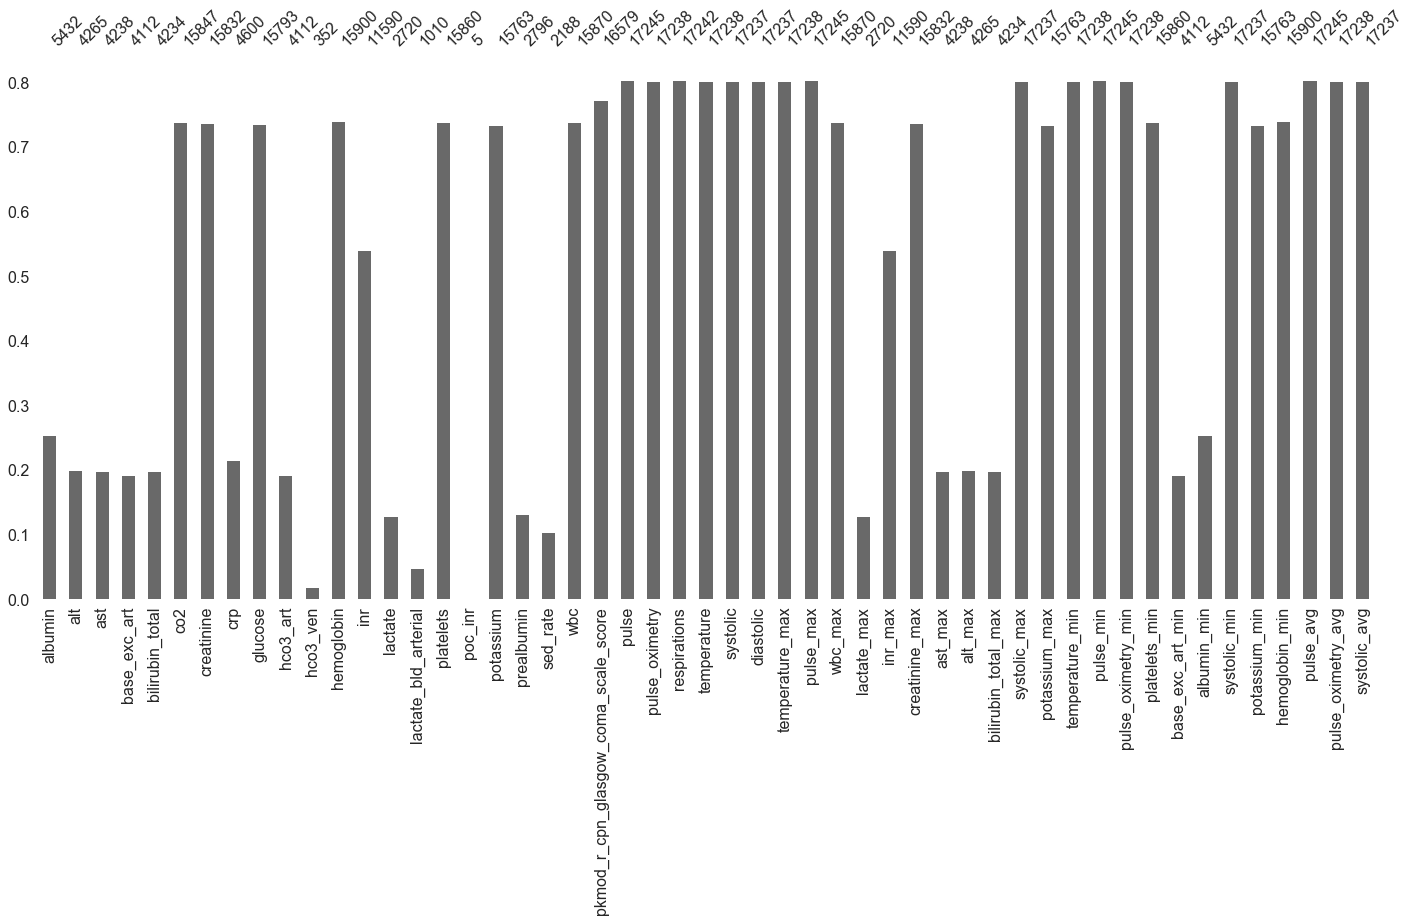

In [227]:
data = merge_all.reset_index().set_index('pat_enc_csn_id')
data = data[~data.index.duplicated(keep='last')]

mn.bar(data[time_vars])

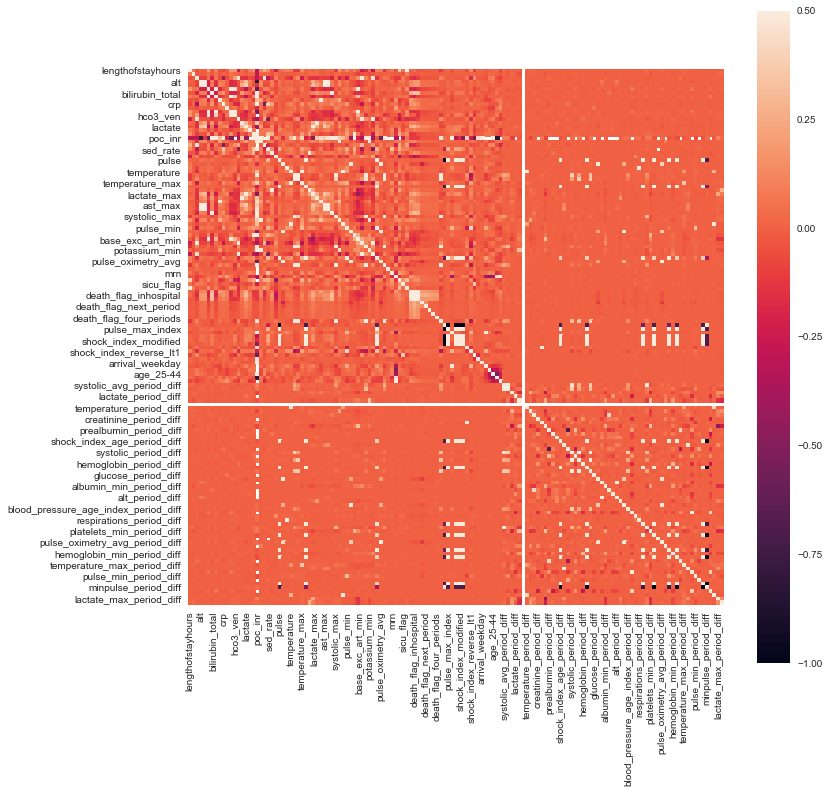

                                      death_flag_this_period
death_flag_this_period                              1.000000
death_flag_inhospital                               0.265162
pulse_oximetry                                      0.209117
death_flag_ever                                     0.189867
death_flag_registry                                 0.181088
pulse_oximetry_avg                                  0.163205
death_flag_next_period                              0.140978
pkmod_r_cpn_glasgow_coma_scale_score                0.129928
pulse_oximetry_min                                  0.129581
pulse_oximetry_avg_period_diff                      0.118622
pulse_oximetry_period_diff                          0.115001
lactate                                             0.112237
lactate_max                                         0.089197
base_exc_art                                        0.084140
base_exc_art_min                                    0.065246
hco3_art                

In [228]:
df_corr = merge_all.corr()

plt.figure(figsize=(12,12))
sns.heatmap(df_corr, vmax=.5, square=True)
plt.show()

print(df_corr[['death_flag_this_period']].abs().sort_values(by='death_flag_this_period', ascending=False))

In [229]:
merge_all.reset_index().groupby('death_flag_next_period').count()

,primarymrn,pat_enc_csn_id,time_sequence,hosp_admsn_time,hosp_dischrg_time,specialty,lengthofstayhours,adm_date,time_elapsed,rxdosemin,...,ast_max_period_diff,hco3_art_period_diff,pulse_min_period_diff,sed_rate_period_diff,pulse_max_index_period_diff,minpulse_period_diff,co2_period_diff,temperature_min_period_diff,lactate_max_period_diff,wbc_max_period_diff
death_flag_next_period,,,,,,,,,,,,,,,,,,,,,
0.0,223080,223080,223080,223080,223076,178188,223076,223080,223080,223080,...,223080,223080,223080,223080,223080,223080,223080,223080,223080,223080
1.0,524,524,524,524,524,510,524,524,524,524,...,524,524,524,524,524,524,524,524,524,524


In [ ]:
#Rough deathrate by MRN
print('Death rate by patient: %0.3f' % (merge_all.reset_index()[['pat_enc_csn_id','death_flag_next_period']].drop_duplicates().death_flag_next_period.mean()))

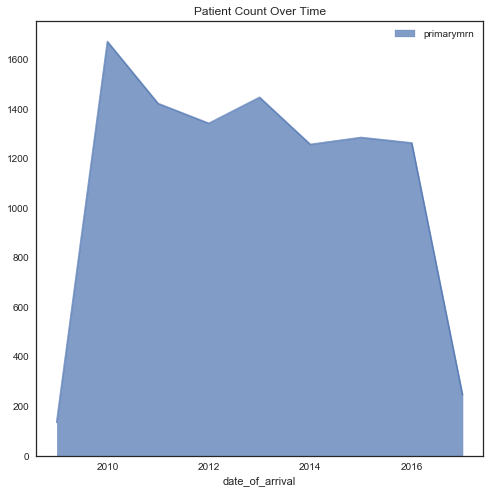

In [219]:
#Count unique patients by year
from pylab import rcParams
rcParams['figure.figsize'] = 8, 8
t_cohort = merge_all.reset_index()[['date_of_arrival','primarymrn']].drop_duplicates()
t_cohort = t_cohort.set_index('date_of_arrival')
t_cohort = t_cohort.resample('12M').count()#.plot()
ax = t_cohort.plot(kind='area', alpha=.7, title="Patient Count Over Time");

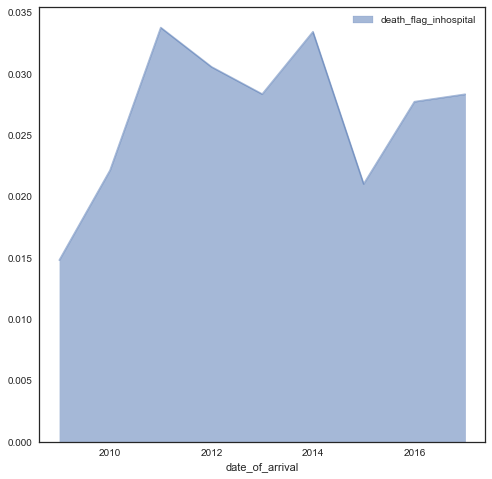

In [223]:
merge_all.reset_index()[['primarymrn','date_of_arrival','death_flag_inhospital']].drop_duplicates().set_index('date_of_arrival')\
.resample('12M').mean().drop('primarymrn',axis=1).plot.area(stacked=False)

In [9]:
sns.boxplot(x="age_bin", y="glucose_random", hue="death_flag_inhospital", data=merge_all, palette="PRGn")

NameError: name 'merge_all' is not defined

In [102]:
merge_all.shape

(227898, 178)